Import the libraries

# Power Load Classification

##  Objective
The goal of this project is to build a machine learning model that classifies the power system's **Load_Type** into one of three categories:
- `Light_Load`
- `Medium_Load`
- `Maximum_Load`

###  Tasks Performed:
- Data cleaning and preprocessing  
- Exploratory data analysis (EDA)  
- Feature engineering  
- Time-based train-test split  
- Model training using Random Forest, XGBoost, Logistic Regression, and SVM  
- Evaluation using Accuracy, Precision, Recall, F1-score, and Confusion Matrix  


In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Install XGBoost if not already
!pip install xgboost
from xgboost import XGBClassifier



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
#  Load dataset
df = pd.read_csv('data/load_data.csv')

# Show head and info
print("🔹 First 5 Rows:\n", df.head())


🔹 First 5 Rows:
           Date_Time  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01-01-2018 00:15   8.753692                                  2.95   
1  01-01-2018 00:30   4.000000                                  4.46   
2  01-01-2018 00:45   3.240000                                  3.28   
3  01-01-2018 01:00   3.310000                                  3.56   
4  01-01-2018 01:15   3.820000                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor          NSM  \
0                     73.210000                         100.0   900.000000   
1                     66.770000                         100.0  1800.0

In [65]:
# Get basic info
print("\n🔹 Info:\n")
print(df.info())


🔹 Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date_Time                             35041 non-null  object 
 1   Usage_kWh                             33482 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  34165 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  33885 non-null  float64
 4   CO2(tCO2)                             34586 non-null  float64
 5   Lagging_Current_Power_Factor          34691 non-null  float64
 6   Leading_Current_Power_Factor          33570 non-null  float64
 7   NSM                                   34586 non-null  float64
 8   Load_Type                             35041 non-null  object 
dtypes: float64(7), object(2)
memory usage: 2.4+ MB
None


In [66]:
# Check for missing values
print("\n🔹 Missing Values:\n")
print(df.isnull().sum())


🔹 Missing Values:

Date_Time                                  0
Usage_kWh                               1559
Lagging_Current_Reactive.Power_kVarh     876
Leading_Current_Reactive_Power_kVarh    1156
CO2(tCO2)                                455
Lagging_Current_Power_Factor             350
Leading_Current_Power_Factor            1471
NSM                                      455
Load_Type                                  0
dtype: int64


In [67]:
# Check unique Load_Type values
print("\n🔹 Unique Load Types:\n", df['Load_Type'].value_counts())


🔹 Unique Load Types:
 Load_Type
Light_Load      18073
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64


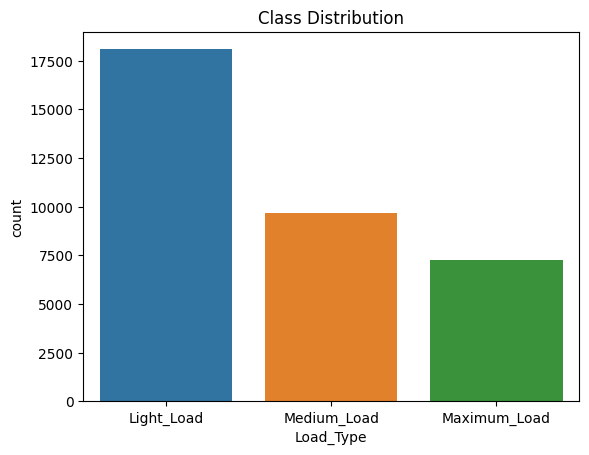

In [68]:
# Class balance
sns.countplot(x='Load_Type', data=df)
plt.title("Class Distribution")
plt.show()


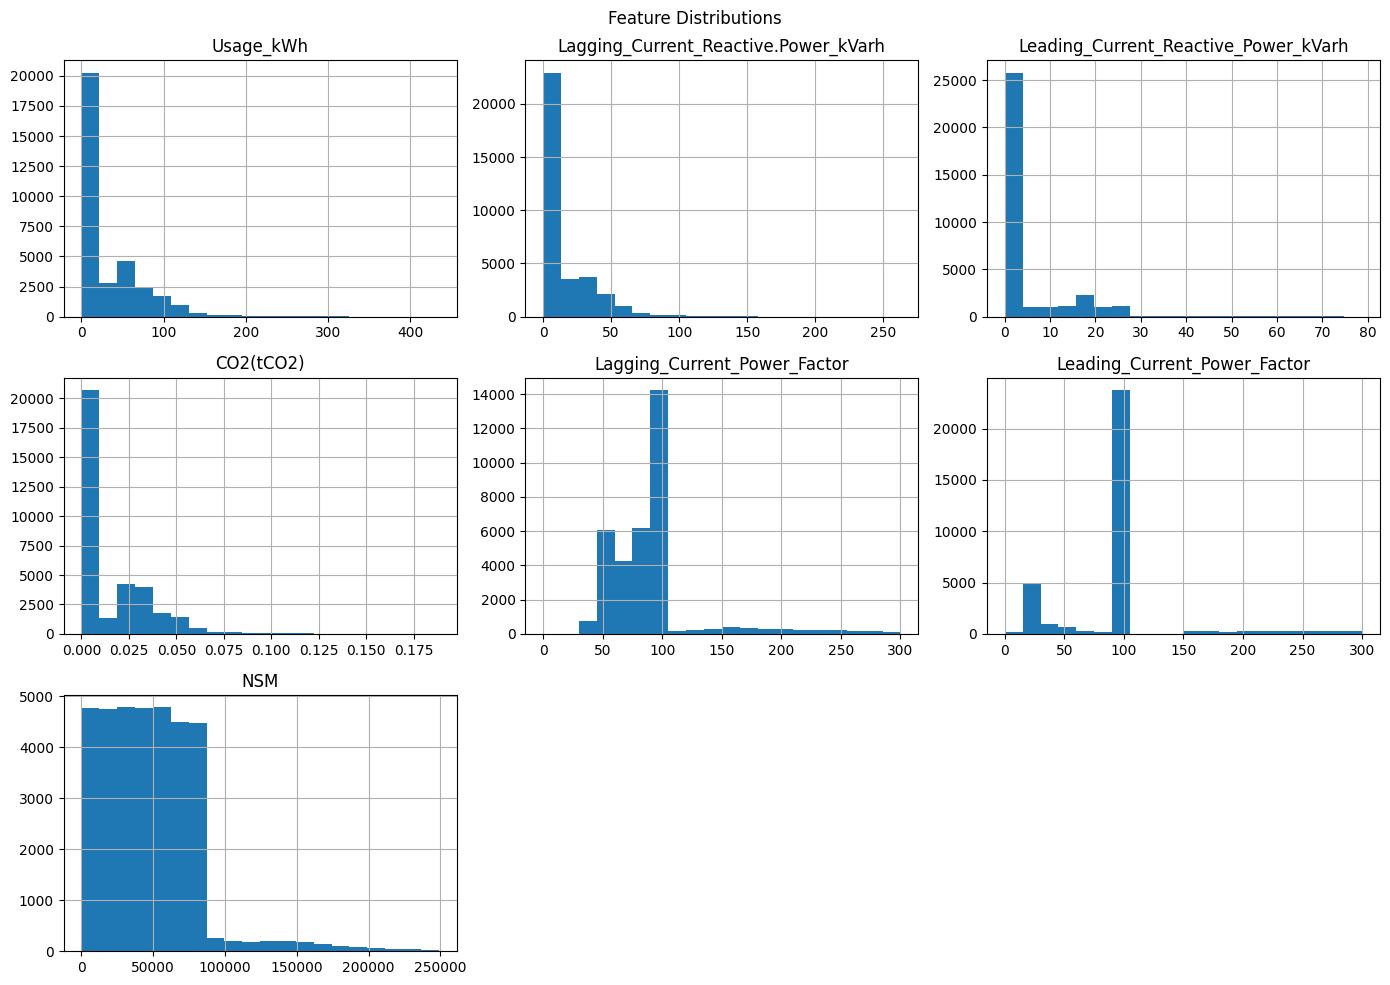

In [69]:
# Histograms for numerical columns
df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()

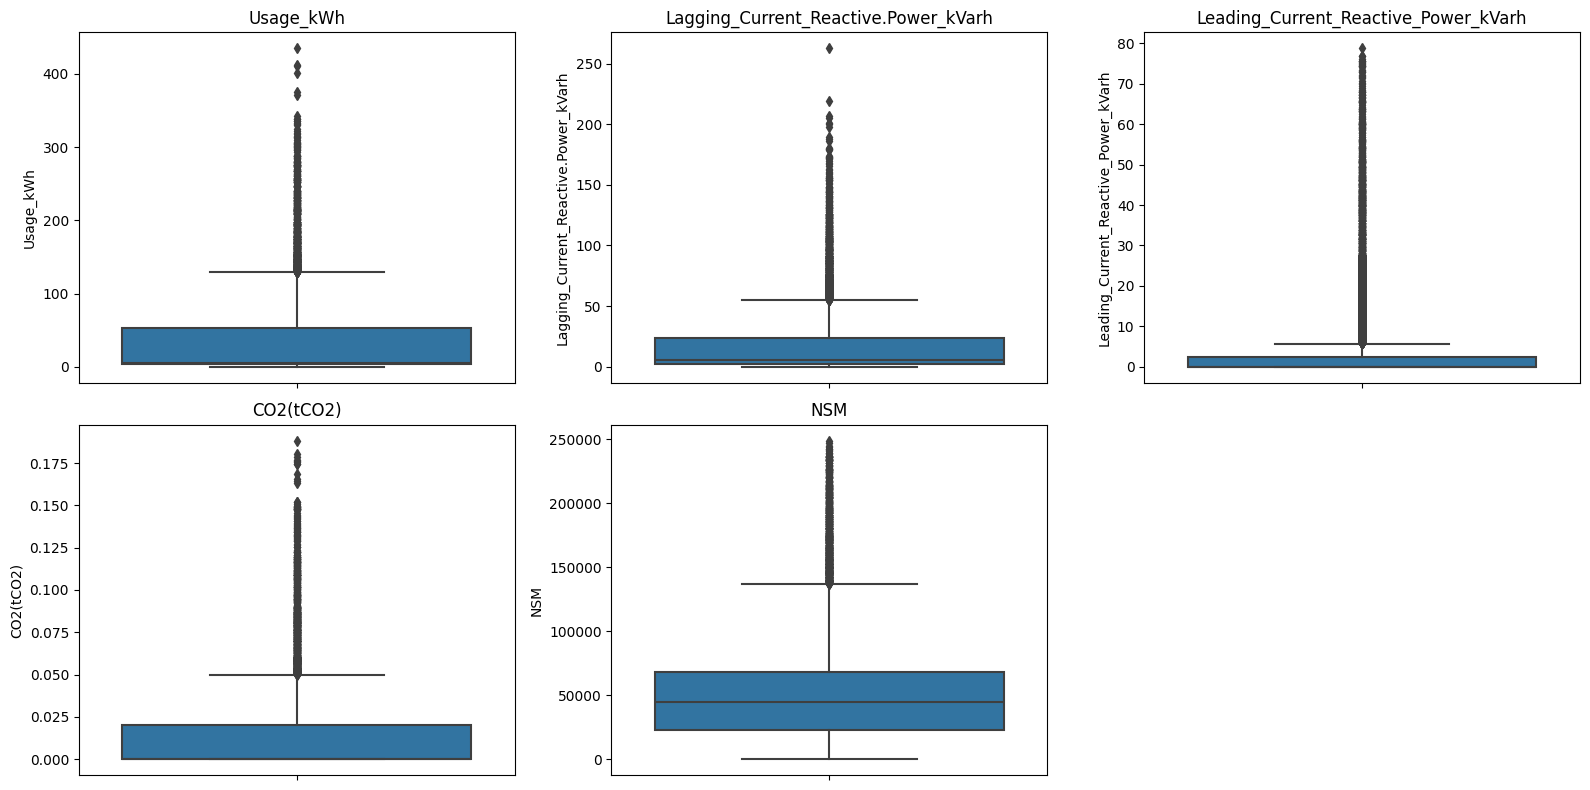

In [70]:
# Boxplots
features_to_plot = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'NSM']

plt.figure(figsize=(16, 8))
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, y=feature)
    plt.title(f"{feature}")
plt.tight_layout()
plt.show()

In [71]:
# Convert datetime and extract Month
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d-%m-%Y %H:%M')
df['Month'] = df['Date_Time'].dt.month
df['Weekday'] = df['Date_Time'].dt.weekday
df['Hour'] = df['Date_Time'].dt.hour

In [72]:
# List of numerical columns
numerical_cols = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                  'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']


In [73]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Label encode target
le = LabelEncoder()
df['Load_Type_Encoded'] = le.fit_transform(df['Load_Type'])

In [74]:
# Final feature set
features = numerical_cols + ['Month', 'Weekday', 'Hour']
X = df[features]
y = df['Load_Type_Encoded']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [75]:
latest_month = df['Date_Time'].dt.month.max()
latest_year = df[df['Month'] == latest_month]['Date_Time'].dt.year.max()

test_df = df[(df['Date_Time'].dt.month == latest_month) & (df['Date_Time'].dt.year == latest_year)]
train_df = df[df['Date_Time'] < test_df['Date_Time'].min()]

X_train = scaler.transform(train_df[features])
y_train = train_df['Load_Type_Encoded']
X_test = scaler.transform(test_df[features])
y_test = test_df['Load_Type_Encoded']

print("Train Size:", len(X_train))
print("Test Size :", len(X_test))


Train Size: 32064
Test Size : 2977


In [76]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [77]:
# XGBoost
xgb_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)


In [78]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [61]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)


🔍 Random Forest Classification Report:

              precision    recall  f1-score   support

  Light_Load       0.99      0.91      0.95      1745
Maximum_Load       0.90      0.92      0.91       528
 Medium_Load       0.84      0.98      0.90       704

    accuracy                           0.93      2977
   macro avg       0.91      0.94      0.92      2977
weighted avg       0.94      0.93      0.93      2977



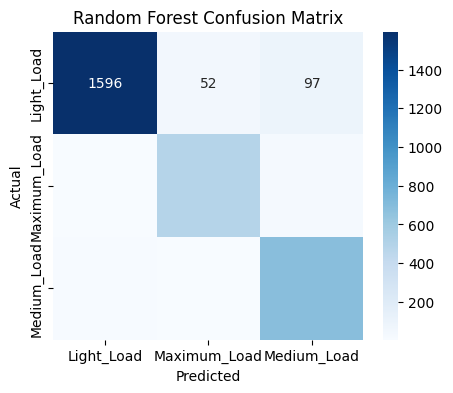


🔍 XGBoost Classification Report:

              precision    recall  f1-score   support

  Light_Load       0.99      0.90      0.94      1745
Maximum_Load       0.86      0.95      0.90       528
 Medium_Load       0.87      0.98      0.92       704

    accuracy                           0.93      2977
   macro avg       0.90      0.94      0.92      2977
weighted avg       0.94      0.93      0.93      2977



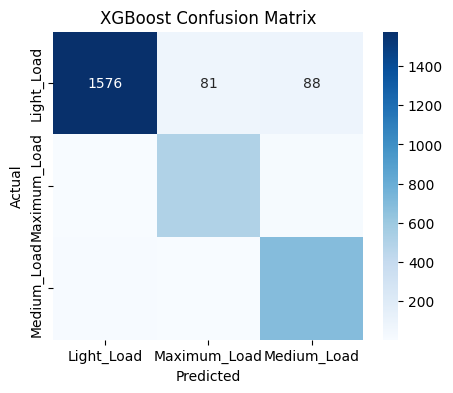


🔍 Logistic Regression Classification Report:

              precision    recall  f1-score   support

  Light_Load       0.95      0.75      0.84      1745
Maximum_Load       0.31      0.29      0.30       528
 Medium_Load       0.35      0.55      0.43       704

    accuracy                           0.62      2977
   macro avg       0.54      0.53      0.52      2977
weighted avg       0.70      0.62      0.65      2977



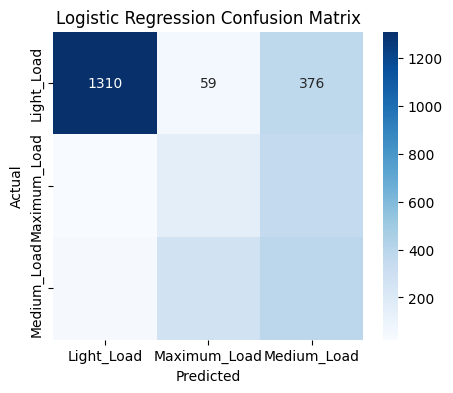


🔍 SVM Classification Report:

              precision    recall  f1-score   support

  Light_Load       0.92      0.89      0.91      1745
Maximum_Load       0.36      0.36      0.36       528
 Medium_Load       0.45      0.49      0.47       704

    accuracy                           0.70      2977
   macro avg       0.58      0.58      0.58      2977
weighted avg       0.71      0.70      0.71      2977



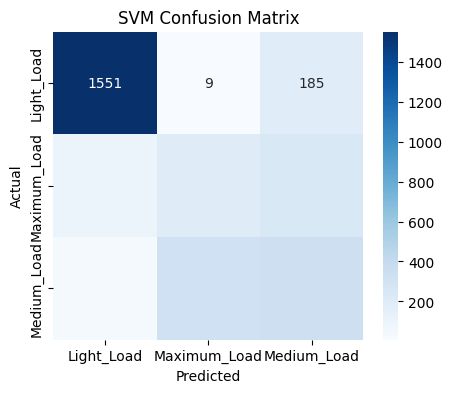

In [62]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n🔍 {name} Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=le.classes_))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)
evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("SVM", y_test, svm_pred)
